# Final BTC Strategy - Inter IIT Tech Meet 2024 submission from IITR

Usage guide:

Step 1: If you need any indicator not already included in the "Defining functions for technical indicators section then add a function which calculates that accordingly

Step 2: Modify the Preprocessing function to include the indicators that you need

Step 3: In the main strategy section, modify the Strategy function according to your strategy. You have to add a column named "Position" to the dataframe which is 1 if you're in a long trade and -1 if you're in a short trade. Signal generation is taken care of in post processing

Step 4: In main run section, import data from a csv or yfinance using fetch_data(ticker) for yfin and create_dataset(csv_path) for importing from a CSV. Then in preprocess function call set the start and end date for backtest.

**NOTE** : to use leverage while backtesting, add `,leverage=2` or whatever leverage you want in SDK backtesting function calls

# Importing modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import warnings
from scipy.stats import chisquare


warnings.simplefilter(action='ignore')

# Importing df

You can use **create_dfset(path)** to import df from a csv file or use **fetch_df(ticker, interval)** to fetch df from yfinance for given ticker with given interval candles

## Using yfinance

In [2]:
def fetch_df(symbol, interval = "1d"):
  symbol = symbol
  # Specify the intraday start and end times
  intraday_start = '2019-09-08'
  intraday_end = "2024-01-01"

  #Download intraday df
  df = yf.download(symbol, start=intraday_start, end=intraday_end, interval=interval)
  df.rename(columns = {'Open':'open'}, inplace = True)
  df.rename(columns = {'Close':'close'}, inplace = True)
  df.rename(columns = {'Low':'low'}, inplace = True)
  df.rename(columns = {'High':'high'}, inplace = True)
  df.rename(columns = {'Volume':'volume'}, inplace = True)
  df.drop('Adj Close',axis=1, inplace=True)

  df.reset_index(inplace=True)
  df.rename(columns = {'Date':'datetime'}, inplace = True)



  return df



# print(x.iloc[2, x.columns.get_loc('open')])  Syntax to access ith entry in a column
# print(x.loc['2021-01-04', 'open'])           Syntax to access entry on some date for some column

## Using CSV

In [3]:
def create_dfset(path):
  df = pd.read_csv(path)
  return df

# Defining functions for technical indicators

Included technical indicators in this file: <br>
SMA<br>
EMA<br>
HeikenAshi<br>
ATR<br>
ADX<br>
Supertrend<br>
Benfords Law <br>
<br>
Refer to the comment above the definition of the function to check the format you get the indicator values in

## ATR


In [4]:
# calculate ATR and add a column with name "ATR"
def ATR(df, n=14):
    df['TR'] = np.maximum(df['high'] - df['low'],
                          np.maximum(abs(df['high'] - df['close'].shift(1)),
                                     abs(df['low'] - df['close'].shift(1)))
                         )
    df[f'ATR'] = df['TR'].ewm(span=n, min_periods=n).mean()
    df.drop('TR', axis=1, inplace=True)

## ADX


In [5]:
#calculate ADX
def ADX(df,lookback=14):
    high = df['high']
    low = df['low']
    close = df['close']
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    df[f"ADX_{lookback}"] = adx_smooth

In [ ]:
import pandas as pd
import numpy as np

def calculate_dynamic_adxr(df, base_lookback=16, atr_period=5):
    df = df.copy()

    # Step 1: Calculate ATR mean
    # Rolling mean of ATR to determine the baseline volatility
    weights = np.arange(1, atr_period + 1)
    df['ATR_mean'] = df['ATR'].rolling(window=atr_period, min_periods=1).mean()
    # df['ATR_mean'] = df['ATR'].ewm(span=atr_period, adjust=False).mean()
    # df['ATR_mean'] = df['ATR'].rolling(window=atr_period, min_periods=1).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    # Step 2: Compute dynamic lookback
    # Avoid division by zero by replacing zero ATR_mean with a small number (e.g., 1e-6)
    df['ATR_mean_safe'] = df['ATR_mean'].replace(0, 1e-6)

    # Compute the dynamic lookback
    df['Dynamic_Lookback'] = (base_lookback * (1 + df['ATR'] / df['ATR_mean_safe'])).round().astype(float)

    # Handle any remaining infinite or NaN values by setting them to base_lookback
    df['Dynamic_Lookback'].replace([np.inf, -np.inf], base_lookback, inplace=True)
    df['Dynamic_Lookback'].fillna(base_lookback, inplace=True)

    # Convert Dynamic_Lookback to integer safely
    df['Dynamic_Lookback'] = df['Dynamic_Lookback'].astype(int)

    # Ensure lookback is at least 1 to avoid invalid shifts
    df['Dynamic_Lookback'] = df['Dynamic_Lookback'].clip(lower=1)

    # Step 3: Calculate ADXR_dynamic
    # Initialize ADXR_dynamic with NaN
    df['ADXR_dynamic'] = np.nan

    # Ensure ADX is present
    if 'ADX_14' not in df.columns:
        raise ValueError("The DataFrame must contain an 'ADX' column.")

    # Iterate over the DataFrame to compute ADXR_dynamic
    for idx in df.index:
        lookback = df.at[idx, 'Dynamic_Lookback']

        # Calculate the shifted index
        # Assuming the DataFrame index is integer-based and sequential
        shifted_idx = idx - lookback

        if shifted_idx >= df.index.min():
            try:
                current_adx = df.at[idx, 'ADX_14']
                shifted_adx = df.at[shifted_idx, 'ADX_14']
                if pd.notna(current_adx) and pd.notna(shifted_adx):
                    df.at[idx, 'ADXR_dynamic'] = (current_adx + shifted_adx) / 2
                else:
                    df.at[idx, 'ADXR_dynamic'] = np.nan
            except KeyError:
                # In case shifted_idx is out of bounds
                df.at[idx, 'ADXR_dynamic'] = np.nan
        else:
            # Insufficient data for dynamic ADXR calculation
            df.at[idx, 'ADXR_dynamic'] = np.nan

    # Optional: Drop intermediate columns if no longer needed
    # df.drop(columns=['ATR_mean', 'ATR_mean_safe', 'Dynamic_Lookback'], inplace=True)

    return df


## Heikenashi

In [7]:
# calculate HA candles and add columns with name "HA_Close" "HA_Open" "HA_High" "HA_Low"
def HA(df):
    df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df['HA_Open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
    df['HA_High'] = df[['high', 'low', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['high', 'low', 'HA_Open', 'HA_Close']].min(axis=1)

## Moving averages

In [8]:
# calculate EMA and add a column with name "EMA_x" where x is the lookback period
def EMA(df, n):
    df['EMA'+str(n)] = df['close'].ewm(span=n, min_periods=n).mean()

# calculate SMA and add a column with name "SMA_x" where x is the lookback period
def SMA(df, n):
    df['SMA'+str(n)] = df['close'].rolling(window=n).mean()

## Benfords Law

In [ ]:
def leading_digit(x):
        if pd.isna(x):  
            return 0
        return int(str(x).lstrip('-0.')[0]) if x != 0 else 0

def benford(df, n=20):
    df['percentage_change'] = df['close'].pct_change() * 100
    df['leading_digit'] = df['percentage_change'].apply(leading_digit)
    benford_dist = np.log10(1 + 1 / np.arange(1, 10))
    df['deviation_flag'] = 0

    for i in range(n+1, len(df)):
        window = df.iloc[i-n:i]

        # Calculate and normalize frequencies
        frequency = window['leading_digit'].value_counts().add(1, fill_value=1).sort_index()
        frequency /= frequency.sum()  # Normalize to sum to 1
        observed = frequency.reindex(range(1, 10), fill_value=0).values * n

        # Scale expected frequencies to match observed sum
        expected = benford_dist * observed.sum()

        # Chi-squared test
        chi2, p_value = chisquare(f_obs=observed, f_exp=expected)
        if p_value < 0.05:
            df.at[i, 'deviation_flag'] = 1

    return df


## PSAR

In [10]:
def calculate_parabolic_sar(df, step=0.02, max_step=0.2):
    # Ensure the DataFrame has the necessary columns
    if not {'HA_High', 'HA_Low', 'HA_Close'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'High', 'Low', and 'Close' columns")

    high = df['HA_High'].values
    low = df['HA_Low'].values
    close = df['HA_Close'].values
    dates = df['datetime'].values
    dates = [pd.to_datetime(date) for date in dates]
    length = len(df)
    
    # Initialize arrays
    psar = [0] * length
    trend = [0] * length  # 1 for uptrend, -1 for downtrend
    ep = [0] * length     # Extreme point
    af = [step] * length  # Acceleration factor



    for i in range(length):
        if dates[i].month%2 == 1 and dates[i].day == 1:
            psar[i] = close[i]
            trend[i] = 0
            ep[i] = close[i]
            continue
        # Determine trend based on prior data
        if close[i] > close[i - 1]:
            trend[i] = 1    # Uptrend
            psar[i] = low[i - 1]
            ep[i] = high[i]
        else:
            trend[i] = -1   # Downtrend
            psar[i] = high[i - 1]
            ep[i] = low[i]
        af[i] = step

        # Calculate PSAR
        prior_psar = psar[i - 1]
        prior_ep = ep[i - 1]
        prior_af = af[i - 1]
        prior_trend = trend[i - 1]

        psar[i] = prior_psar + prior_af * (prior_ep - prior_psar)

        # Adjust PSAR to not penetrate extremes
        if prior_trend == 1:
            psar[i] = min(psar[i], low[i - 1], low[i - 2])
        else:
            psar[i] = max(psar[i], high[i - 1], high[i - 2])

        # Determine trend and adjust EP and AF
        if prior_trend == 1:
            if low[i] < psar[i]:
                # Reversal to downtrend
                trend[i] = -1
                psar[i] = prior_ep
                ep[i] = low[i]
                af[i] = step
            else:
                trend[i] = prior_trend
                if high[i] > prior_ep:
                    ep[i] = high[i]
                    af[i] = min(prior_af + step, max_step)
                else:
                    ep[i] = prior_ep
                    af[i] = prior_af
        else:
            if high[i] > psar[i]:
                # Reversal to uptrend
                trend[i] = 1
                psar[i] = prior_ep
                ep[i] = high[i]
                af[i] = step
            else:
                trend[i] = prior_trend
                if low[i] < prior_ep:
                    ep[i] = low[i]
                    af[i] = min(prior_af + step, max_step)
                else:
                    ep[i] = prior_ep
                    af[i] = prior_af

    # Assign the calculated PSAR values to the DataFrame
    df['PSAR'] = psar

## Some Calculations

In [11]:
import numpy as np
import pandas as pd

def kama(df, source, n=10, sc_fastest=0.666, sc_slowest=0.0645):
    price = df[source].replace(0, np.nan).fillna(method='ffill')  # Handle zeroes and NaNs
    # Calculate efficiency ratio (ER)
    change = abs(price - price.shift(n))
    volatility = abs(price - price.shift(1)).rolling(n).sum()
    eff_ratio = (change / volatility).fillna(0)  # Avoid NaN in eff_ratio

    # Calculate smoothing constant (SC)
    sc = (eff_ratio * (sc_fastest - sc_slowest) + sc_slowest) ** 2
    # print("smoothing constant",sc)
    kama = pd.Series(index=price.index, dtype=float)
    kama[:n] = np.nan  # Fill first `n` values with NaN
    kama[n-1] = price[:n].mean()  # Initialize with the mean of the first `n` prices
    for i in range(n, len(price)):
        kama.iloc[i] = kama.iloc[i-1] + sc.iloc[i] * (price.iloc[i] - kama.iloc[i-1]) if sc.iloc[i] > 0 else kama[i-1]

    return pd.Series(kama, index=df.index, name='KAMA')


In [12]:
def moving_average(df, source, length, ma_type):
    if ma_type == "SMA":
        return df[source].rolling(window=length).mean()
    elif ma_type == "EMA":
        return df[source].ewm(span=length, adjust=False).mean()
    elif ma_type == "SMMA (RMA)":
        return df[source].ewm(alpha=1.0 / length).mean()
    elif ma_type == "WMA":
        weights = np.arange(1, length + 1)
        return df[source].rolling(length).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    elif ma_type=="KAMA":
        df[f'kama_{source}']=kama(df,source,length,0.666,0.0645)

        return df[f'kama_{source}']
    else:
        raise ValueError("Invalid moving average type")

In [13]:
def rsi_function(df, source_col, length, mode_ma):
    """Calculate the Relative Strength Index (RSI)."""

    price_change = df[source_col].diff()
    df[f'UP_{source_col}'] = price_change.clip(lower=0)  # Positive changes
    df[f'DOWN_{source_col}'] = -price_change.clip(upper=0)  # Negative changes


    # Calculate upward and downward movements
    up = moving_average(df,f'UP_{source_col}', length, mode_ma)  # Positive changes
    dn = moving_average(df,f'DOWN_{source_col}', length, mode_ma)  # Negative changes

    # Calculate RSI
    up.fillna(0, inplace=True)
    dn.fillna(0, inplace=True)

    rsi = 100 - (100 / (1 + up / dn))

    # Handle cases where dn is zero
    rsi[dn == 0] = 100
    rsi[up == 0] = 0

    return rsi

In [14]:
def calculation(df,mode_ma):

    length=7
    maLength=4
    mode_ma1='WMA'
    df['tsi']=rsi_function(df,'HA_Close',length,mode_ma)
    df['tsiMA']=moving_average(df,'tsi',maLength,mode_ma1)

In [15]:
#calculate RSI
def rsi(df, lookback=14):
    close = df['close']
    ret = close.diff().dropna()
    up = []
    down = []
    for i in range(len(ret)):
        if ret.iloc[i] < 0:
            up.append(0)
            down.append(ret.iloc[i])
        else:
            up.append(ret.iloc[i])
            down.append(0)
    up_series = pd.Series(up, index=ret.index)
    down_series = pd.Series(down, index=ret.index).abs()
    up_ewm = up_series.ewm(com=lookback - 1, adjust=False).mean()
    down_ewm = down_series.ewm(com=lookback - 1, adjust=False).mean()
    rs = up_ewm / down_ewm
    rsi = 100 - (100 / (1 + rs))
    df["RSI"] = rsi.reindex(df.index)

# Preprocessing on the df

Calculate all the indicators you need and select the interval you want to bactest on using this function

In [16]:
def preprocess(df, start, end):
    HA(df)
    ATR(df)
    rsi(df, 14)
    ADX(df, 14)
    calculate_parabolic_sar(df)
    df=benford(df)
    df=calculate_dynamic_adxr(df, 16)


    # Filter the dfframe to values between start and end
    df = df[(df['datetime'] >= start) & (df['datetime'] <= end)]
    df.reset_index(drop=True, inplace=True)

    # Ensure 'datetime' column is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize Position and signals
    df['Position'] = 0
    df['signals'] = 0




    return df


# Postprocessing the df

Assumptions: You feed a dfframe in the function which has a column named "Position" which is 1 if you're in a long trade and "-1" if you're in a short trade. The function handles the signal generation

In [17]:
def post_process(df):
    # Initialize variables
    compound_returns = [1000]  # Starting capital
    entry_price = None
    entry_amount = None
    transaction_fee = 0.0015  # 0.15% transaction fee

    # Iterate through the DataFrame
    for i in range(1, len(df)):
        # If the position remains the same
        if df.loc[i, "Position"] == df.loc[i - 1, "Position"]:
            if df.loc[i, "Position"] == 1:  # Long position
                compound_returns.append((df.loc[i, "close"] / entry_price) * entry_amount)
            elif df.loc[i, "Position"] == -1:  # Short position
                compound_returns.append(((entry_price - df.loc[i, "close"] + entry_price) / entry_price) * entry_amount)
            else:  # No position (hold)
                compound_returns.append(compound_returns[-1])
        else:  # If the position changes
            if df.loc[i, "Position"] == 1:  # Entering a long position
                if df.loc[i - 1, "Position"] == 0:  # From no position to long
                    entry_price = df.loc[i - 1, "close"]
                    entry_amount = compound_returns[-1]
                    compound_returns.append((df.loc[i, "close"] / entry_price) * entry_amount)
                else:  # From short to long
                    entry_price = df.loc[i - 1, "close"]
                    entry_amount = compound_returns[-1] * (1 - transaction_fee)
                    compound_returns.append((df.loc[i, "close"] / entry_price) * entry_amount)
            elif df.loc[i, "Position"] == -1:  # Entering a short position
                if df.loc[i - 1, "Position"] == 0:  # From no position to short
                    entry_price = df.loc[i - 1, "close"]
                    entry_amount = compound_returns[-1]
                    compound_returns.append(((entry_price - df.loc[i, "close"] + entry_price) / entry_price) * entry_amount)
                else:  # From long to short
                    entry_price = df.loc[i - 1, "close"]
                    entry_amount = compound_returns[-1] * (1 - transaction_fee)
                    compound_returns.append(((entry_price - df.loc[i, "close"] + entry_price) / entry_price) * entry_amount)
            else:  # Exiting to no position
                compound_returns.append(compound_returns[-1] * (1 - transaction_fee))

    # Add signals and trade type columns
    df["signals"] = 0
    df["trade_type"] = "hold"

    for i in range(1, len(df)):
        if df.loc[i, "Position"] != df.loc[i - 1, "Position"]:
            if df.loc[i, 'Position'] == 1:
                if df.loc[i-1, 'Position'] == 0:
                    df.loc[i-1, 'signals'] = 1
                    df.loc[i-1, 'trade_type'] = 'long'
                else:
                    df.loc[i-1, 'signals'] = 2
                    df.loc[i-1, 'trade_type'] = 'long_reversal'
            elif df.loc[i, 'Position'] == -1:
                if df.loc[i-1, 'Position'] == 0:
                    df.loc[i-1, 'signals'] = -1
                    df.loc[i-1, 'trade_type'] = 'short'
                else:
                    df.loc[i-1, 'signals'] = -2
                    df.loc[i-1, 'trade_type'] = 'short_reversal'
            else:
                if df.loc[i-1, 'Position'] == 1:
                    df.loc[i-1, 'signals'] = -1
                    df.loc[i-1, 'trade_type'] = 'square_off'
                else:
                    df.loc[i-1, 'signals'] = 1
                    df.loc[i-1, 'trade_type'] = 'square_off'
                    
                              

    return df, compound_returns

# Plotting

In [18]:
def plot_results(compound_returns, buy_and_hold_returns, dates, drawdowns):
    plt.figure(figsize=(12, 10))
    plt.subplot(3, 1, 1)
    plt.plot(dates,compound_returns, label="Strategy Returns: compound")
    plt.plot(dates,buy_and_hold_returns, label="Buy and Hold Returns")
    plt.legend()
    plt.title('Compounded returns of SPSAR+TAI strategy on ETH')

    # Filter for the first dates of each month
    first_dates = dates[dates.dt.is_month_start].iloc[::6]

    # Plot the filtered dates
    plt.xticks(ticks=first_dates, labels=[date.strftime('%Y-%m-%d') for date in first_dates])

    plt.xlabel('Date')
    plt.show()


    plt.figure(figsize=(12, 10))
    plt.subplot(3, 1, 1)
    for i in range(len(drawdowns)):
        drawdowns[i] *= 16.6/20
    plt.plot(dates,drawdowns, label="Drawdowns")
    plt.legend()
    plt.title('Drawdowns of SPSAR+TAI strategy on ETH')
    # Filter for the first dates of each month
    first_dates = dates[dates.dt.is_month_start].iloc[::6]

    # Plot the filtered dates
    plt.xticks(ticks=first_dates, labels=[date.strftime('%Y-%m-%d') for date in first_dates])
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')


# Main Strategy

In [19]:
def Strategy(df, atr_multiplier=3, stoploss=0):
    curr=0
    mode_ma='KAMA'
    calculation(df,mode_ma)
    df['ATR_D']=np.abs(df['ATR'].diff())
    df['close_D']=np.abs(df['close'].diff())
    df['ATR/close'] = df['ATR_D'].rolling(15).mean()/df['close_D'].rolling(15).mean()
    df['ATR/close']=df['ATR/close'].rolling(30).mean()
    df['ATRdiff']=np.abs(df['ATR']-df['ATR'].shift(1))
    for i in range(15, len(df) - 1):
        curr_atr = df.loc[i, 'ATR']
        tsi_slope = df.loc[i, 'ADX_14'] - df.loc[i - 2, 'ADX_14']


        # Long condition
        if( (df['tsi'][i] > df['tsiMA'][i]*1.05 or 1.05*df.loc[i, "PSAR"] < df.loc[i, "HA_Close"]) and df['ADXR_dynamic'][i]>20 and df['ADX_14'][i]<25  and df['deviation_flag'][i]==0 and  df['Position'][i] != 1 ):# and (tsi_slope>0 and tsi_slope>0.1) 
            # Enter a long position and set the signal to 1
            df.loc[i + 1, 'Position'] = 1
            curr=df['tsi'][i]
            stoploss = df.loc[i, 'close'] - curr_atr * (atr_multiplier + 1)
        # Short condition
        elif df['low'][i-1] > df['EMA10'][i-1] and df['close'][i] < df['low'][i-1] and df['ADXR_dynamic'][i]>20 and df['ADX_14'][i]<25  and df['deviation_flag'][i]==0 and  df['Position'][i]!=-1 :# and tsi_slope<0:
            df.loc[i + 1, 'Position'] = -1
            stoploss = df.loc[i, 'close'] + curr_atr * (atr_multiplier - 1)

        else:
            # If the current position is long
            if df.loc[i, 'Position'] == 1:
                df.loc[i + 1, 'Position'] = 1
                # Exit on stop loss or take profit
                if df.loc[i, 'close'] <= stoploss or df['tsi'][i]<0.95*curr or df["ADX_14"][i] > 65 or (df['HA_Close'][i]<df['HA_Open'][i] and df['HA_Close'][i-1]<df['HA_Open'][i-1] and df['ATRdiff'][i]/df['ATR'][i]>0.15):
                    df.loc[i + 1, 'Position'] = 0
                else:
                    stoploss = max(stoploss, df.loc[i, 'close'] - curr_atr * (atr_multiplier + 1))

            # If the current position is short
            elif df.loc[i, 'Position'] == -1:
                df.loc[i + 1, 'Position'] = -1
                # Exit on stop loss or take profit
                if df.loc[i, 'close'] >= stoploss or df["ADX_14"][i] > 65 or (df['HA_Close'][i]>df['HA_Open'][i] and df['HA_Close'][i-1]>df['HA_Open'][i-1] and df['ATRdiff'][i]/df['ATR'][i]>0.15):
                    df.loc[i + 1, 'Position'] = 0
                else:
                    stoploss = min(stoploss, df.loc[i, 'close'] + curr_atr * (atr_multiplier - 1))

            # If the current position is neutral
            else:
                df.loc[i + 1, 'Position'] = 0
    return df

# Main Run

In [20]:
# df = pd.read_csv("binance_data/BTC_USDT_1d_binance_2024.csv")
# df = preprocess(df, '2024-01-01', '2024-12-31')

main_df = pd.read_csv("BTC data/BTC_2019_2023_1d.csv")
# df = pd.read_csv("sol_data.csv")
df = preprocess(main_df, '2018-01-01', '2023-12-31')

EMA(df,10)
df = Strategy(df)
# print(df['tsi'])
df, compound_returns = post_process(df)
drawdowns =[0]
max_val = 1000

#plot_results(compound_returns, df['close']*1000/df.loc[0, 'close'], df['datetime'], drawdowns)

# Testing using SDK

In [21]:
from untrade.client import Client

def perform_backtest_quarterly(df, csv_file_path="output.csv", leverage=1):
    # Create an instance of the untrade client
    client = Client()

    df.to_csv(csv_file_path, index=False)


    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="maverick",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=leverage,  # Adjust leverage as needed
        result_type = "Q"
    )

    for value in result:
        print(value)

def perform_backtest_overall(df, csv_file_path="output.csv", leverage=1):
    # Create an instance of the untrade client
    client = Client()

    df.to_csv(csv_file_path, index=False)

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="maverick",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=leverage,  # Adjust leverage as needed
    )

    # Get the last value of backtest result
    value = ""
    for i in result:
        value += i

    print(value)



In [22]:
perform_backtest_overall(df,leverage=1)

data: {
  "jupyter_id": "maverick",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2019-09-08 00:00:00",
      "Total Trades": 63,
      "Leverage Applied": 1.0,
      "Winning Trades": 37,
      "Losing Trades": 26,
      "No. of Long Trades": 44,
      "No. of Short Trades": 19,
      "Benchmark Return(%)": 307.193097,
      "Benchmark Return(on $1000)": 3071.930968,
      "Win Rate": 58.730159,
      "Winning Streak": 10,
      "Losing Streak": 9,
      "Gross Profit": 5802.037272,
      "Net Profit": 5707.537272,
      "Average Profit": 90.59583,
      "Maximum Drawdown(%)": 11.347488,
      "Average Drawdown(%)": 1.371972,
      "Largest Win": 2300.012739,
      "Average Win": 175.718905,
      "Largest Loss": -131.626581,
      "Average Loss": -30.540854,
      "Maximum Holding Time": "109 days 0:0:0",
      "Average Holding Time": "13 days 18:40:0",
      "Maximum Adverse Excursion": 15.259304,
      "Average A

In [23]:
perform_backtest_overall(df,leverage=2)

data: {
  "jupyter_id": "maverick",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2019-09-08 00:00:00",
      "Total Trades": 63,
      "Leverage Applied": 2.0,
      "Winning Trades": 37,
      "Losing Trades": 26,
      "No. of Long Trades": 44,
      "No. of Short Trades": 19,
      "Benchmark Return(%)": 307.193097,
      "Benchmark Return(on $1000)": 3071.930968,
      "Win Rate": 58.730159,
      "Winning Streak": 10,
      "Losing Streak": 9,
      "Gross Profit": 5802.037272,
      "Net Profit": 5707.537272,
      "Average Profit": 90.59583,
      "Maximum Drawdown(%)": 11.347488,
      "Average Drawdown(%)": 1.371972,
      "Largest Win": 2300.012739,
      "Average Win": 175.718905,
      "Largest Loss": -131.626581,
      "Average Loss": -30.540854,
      "Maximum Holding Time": "109 days 0:0:0",
      "Average Holding Time": "13 days 18:40:0",
      "Maximum Adverse Excursion": 15.259304,
      "Average A

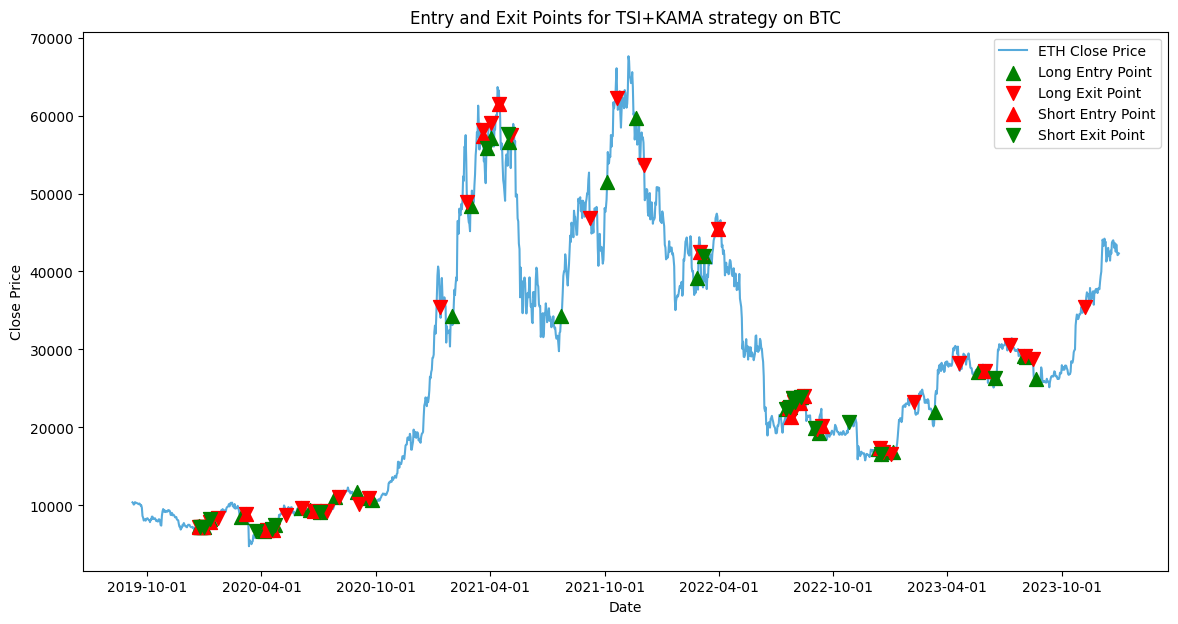

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(df['datetime'], df['close'], label='ETH Close Price', color='#56aadb', zorder=1)


# Filter for the first dates of each month
first_dates = df[df['datetime'].dt.is_month_start].iloc[::6]


# Plot the filtered dates
plt.xticks(ticks=first_dates['datetime'], labels=[date.strftime('%Y-%m-%d') for date in first_dates['datetime']])

long_entry_points = []
long_exit_points = []
short_entry_points = []
short_exit_points = []

in_trade = False
for i in range(len(df)):
    if df.loc[i, 'signals'] == 1:
        if in_trade:
            short_exit_points.append(df.iloc[i])
        else:
            long_entry_points.append(df.iloc[i])
        in_trade = not in_trade
    elif df.loc[i, 'signals'] == -1:
        if in_trade:
            long_exit_points.append(df.iloc[i])
        else:
            short_entry_points.append(df.iloc[i])
        in_trade = not in_trade
    elif df.loc[i, 'signals'] == 2:
        long_entry_points.append(df.iloc[i])
        short_exit_points.append(df.iloc[i])
        in_trade = True
    elif df.loc[i, 'signals'] == -2:
        short_entry_points.append(df.iloc[i])
        long_exit_points.append(df.iloc[i])
        in_trade = True


# Convert lists to DataFrames
long_entry_points_df = pd.DataFrame(long_entry_points)
long_exit_points_df = pd.DataFrame(long_exit_points)
short_entry_points_df = pd.DataFrame(short_entry_points)
short_exit_points_df = pd.DataFrame(short_exit_points)

# Plot long entry points
plt.scatter(long_entry_points_df['datetime'], long_entry_points_df['close'], marker='^', color='green', label='Long Entry Point', s=100, zorder=2)

# Plot long exit points
plt.scatter(long_exit_points_df['datetime'], long_exit_points_df['close'], marker='v', color='red', label='Long Exit Point', s=100, zorder=2)

# Plot short entry points
plt.scatter(short_entry_points_df['datetime'], short_entry_points_df['close'], marker='^', color='red', label='Short Entry Point', s=100, zorder=2)

# Plot short exit points
plt.scatter(short_exit_points_df['datetime'], short_exit_points_df['close'], marker='v', color='green', label='Short Exit Point', s=100, zorder=2)

plt.title('Entry and Exit Points for TSI+KAMA strategy on BTC')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()